In [49]:
%%capture
# required libraries

%pip install numpy pandas tensorflow scikit-learn seaborn matplotlib obspy keras 

import pandas as pd
import numpy as np
import seaborn as sns
from obspy import read
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from obspy.signal.invsim import cosine_taper
from scipy.signal import welch
from obspy.signal.freqattributes import spectrum

In [50]:
import os

catalog = pd.read_csv('data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv')
training_data = {}

for index, row in catalog.iterrows():
    try:
        file_path = f'data/lunar/training/data/S12_GradeA/{row.filename}.mseed'
        
        # Check if the file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        
        # Read the data
        data = read(file_path)
        
        # Ensure the necessary columns are present
        if 'time_rel(sec)' not in row or 'mq_type' not in row:
            raise KeyError("Missing required columns in the row data")
        
        # Add to training_data
        training_data[row.evid] = {
            'data': data,
            'rel_time': row['time_rel(sec)'],
            'type': row['mq_type']
        }
    
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except KeyError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Error: File not found: data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed


In [51]:
events = training_data.keys()

WINDOW = 10000 # 10,000 secs for training window

nfft = 1024  # Number of points in FFT
width = 3 

def convert_to_low_res(tr):
    minfreq = 0.5
    maxfreq = 1.0
    
    # Going to create a separate trace for the filter data
    trace = tr.copy()
    tr.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    
    # Step 2: Define your parameters
    fs = trace.stats.sampling_rate  # Sampling frequency
    n_seconds = int(trace.stats.npts / fs)  # Total number of seconds
    n_bins = 10  # Number of frequency bands
    freq_bins = np.linspace(0, fs / 2, n_bins + 1)  # Define frequency bands
    amplitudes = np.zeros((n_seconds, n_bins))  # Prepare an array to store amplitudes
    
    # Step 3: Process the data for each second
    for i in range(int(n_seconds/width)):
        start = i*width
        segment = trace.data[int(start * fs):int((start + width) * fs)]
        
        # # Apply a taper to minimize edge effects
        # taper = cosine_taper(len(segment), 0.1)  # 10% taper
        # segment *= taper
    
        # Compute the PSD using Welch's method
        f, Pxx = welch(segment, fs, nperseg=fs * width, nfft=nfft, scaling='density')
    
        # Step 4: Aggregate the data into frequency bins
        for i in range(n_bins):
            mask = (f >= freq_bins[i]) & (f < freq_bins[i + 1])
            amplitudes[start, i] = np.sqrt(np.sum(Pxx[mask]))

    return amplitudes

In [52]:
# intial calulations for lowres data was done in tensorflow.ipynb
# pull from reflextion

for event in events:
    training_data[event]['data_low_res'] = np.loadtxt('processed_data/low_res_' + event)

In [53]:
CONTEXT_SIZE = 10000
OVERLAP = 2000

def generate_samples(event):
    X = []
    Y = []
    
    data = event['data_low_res']
    event_time = event['rel_time']
    start = 0
    while start < len(data) - CONTEXT_SIZE:
        X.append(data[start:start+CONTEXT_SIZE])
        Y.append(
            1 if start <= event_time and start+CONTEXT_SIZE > event_time else 0
        )
        start += int(CONTEXT_SIZE - OVERLAP)

    return X,Y


X = []
Y = []

for event in events:
    event_X, event_Y = generate_samples(training_data[event])
    X = X + event_X
    Y = Y + event_Y



X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=69)

In [54]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [55]:
# Assuming X and Y are already generated from your dataset
X = np.array(X)
Y = np.array(Y)

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=69)


In [56]:
X

array([[[1.39614550e-53, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.37377639e-49, 0.00000000e+00, 1.44382554e-48, ...,
         0.00000000e+00, 1.26190948e-49, 0.00000000e+00],
        [2.32519732e-48, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14331841e-13, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [6.50635612e-14, 0.00000000e+00, 8.54062310e-14, ...,
         0.00000000e+00, 5.74078878e-15, 0.00000000e+00],
        [1.26724467e-13, 0.00000000e+00, 2.69313023e-13, ...,
         0.00000000e+00, 5.71239795e-15, 0.00000000e+00]],

       [[4.00755243e-11, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.80436590e-11, 0.00000000e+00, 1.19511147e-10, ...,
         0.00000000e+00, 1.36508877e-12, 0.00000000e+00],
        [5.66937918e-11, 

In [57]:
Y[:1000]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [58]:
from sklearn.decomposition import PCA
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Set the number of components you want to keep
n_components = 50  # Adjust this number based on your needs
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_reshaped)

In [59]:
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

X_test_pca = pca.fit_transform(X_test_reshaped)

In [60]:
# trying to see if radial kernel function will work well
svm_classifier = SVC(kernel='rbf', gamma="auto", random_state=69)

# Train the SVM classifier on the training data
svm_classifier.fit(X_train_pca, Y_train)

SVC(gamma='auto', random_state=69)

In [61]:
Y_pred = svm_classifier.predict(X_test_pca)


In [62]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 89.33%


radial kernel: Accuracy: 89.33%

In [63]:
svm_classifier_poly = SVC(kernel='poly', degree=3, C=2, random_state=69)

# Train the SVM classifier on the training data
svm_classifier_poly.fit(X_train_pca, Y_train)

SVC(C=2, kernel='poly', random_state=69)

In [64]:
Y_pred = svm_classifier_poly.predict(X_test_pca)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.33%


poly kernel: Accuracy: 93.33%

In [45]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

n_components = 75
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_reshaped)

X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

X_test_pca = pca.fit_transform(X_test_reshaped)

In [46]:
svm_classifier_poly.fit(X_train_pca, Y_train)

Y_pred = svm_classifier_poly.predict(X_test_pca)

SVC(kernel='poly', random_state=69)

In [47]:
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.33%


In [65]:
svm_classifier_poly4 = SVC(kernel='poly', degree=4, C=2, random_state=69)

# Train the SVM classifier on the training data
svm_classifier_poly4.fit(X_train_pca, Y_train)

Y_pred = svm_classifier_poly4.predict(X_test_pca)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 92.00%


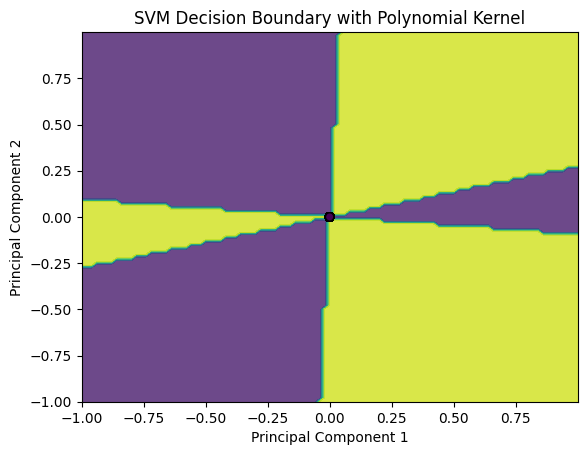

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_reshaped)

# svmModel
svm_model = SVC(kernel='poly', degree=3, C=1)
svm_model.fit(X_train_pca, Y_train)

h = .02
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train, edgecolors='k', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary with Polynomial Kernel')
plt.show()
